# Simple Recommender

## Imports

In [2]:
import pandas as pd

## Load Datasets

In [3]:
metadata = pd.read_csv('Data/movies_metadata.csv', low_memory=False)

In [4]:
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


## Calculating Weighter Rating 
### (WR) = (v.R)+(m.C)/(v+m)
### Calculate C

In [67]:
C = metadata['vote_average'].mean()
print(C)

5.618207215133889


### Calculate the minimum number of votes required to be in the chart, m

In [6]:
m = metadata['vote_count'].quantile(0.9)
print(m)

160.0


### Filter out all qualified movies into a new DataFrame


In [7]:
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

### Function that computes the weighted rating of each movie


In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # calculation based on the IMDB formula
    return (v*R + m*C)/(v+m)

### Define a new feature 'score' and calculate its value with `weighted_rating()`


In [ ]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

### Sort movies based on score calculated above

In [9]:
q_movies = q_movies.sort_values('score', ascending=False)

In [10]:
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


# Content Based Recommender

In [11]:
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

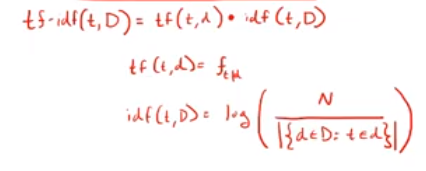

In [55]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
q_movies['overview'] = q_movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(q_movies['overview'])

tfidf_matrix.shape

(4606, 19694)

In [56]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [57]:
indices = pd.Series(q_movies.index, index=q_movies['title']).drop_duplicates()

In [58]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    
    return q_movies['title'].iloc[movie_indices]

In [19]:
get_recommendations('The Godfather')

5345          K-19: The Widowmaker
1189                      Das Boot
2965       The World Is Not Enough
5743                       Solaris
4238     Atlantis: The Lost Empire
40024            Deepwater Horizon
461           Hot Shots! Part Deux
897          2001: A Space Odyssey
7101          The Butterfly Effect
10384                   Flightplan
Name: title, dtype: object

# Credits, Genres and Keywords Based Recommender

In [9]:
credits = pd.read_csv('Data/credits.csv')
keywords = pd.read_csv('Data/keywords.csv')

In [10]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
q_movies['id'] = q_movies['id'].astype('int')

In [14]:
q_movies = q_movies.merge(credits, on='id')
q_movies = q_movies.merge(keywords, on='id')

In [16]:
q_movies.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


### From your new features, cast, crew and keywords, you need to extract the three most important actors, the director and the keywords associated with that movie. 

In [17]:
from ast import literal_eval

features = ['cast', 'keywords', 'genres', 'crew']
for feature in features:
    q_movies[feature] = q_movies[feature].apply(literal_eval)

In [18]:
import numpy as np

# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):    
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [19]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 2:
            names = names[:3]
        return names
    
    return []

In [21]:
q_movies['director'] = q_movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    q_movies[feature] = q_movies[feature].apply(get_list)

In [22]:
q_movies[['title', 'cast', 'keywords', 'director', 'genres']].head(3)

,title,cast,keywords,director,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy]",John Lasseter,"[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston,"[Adventure, Fantasy, Family]"
2,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence]",Charles Shyer,[Comedy]


In [42]:
def clean_data(x):
    if isinstance(x, list):
        str1 = ''.join(str(e) for e in x)
        return [str.lower(i.replace(" ", "")) for i in str1]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['cast', 'crew', 'director', 'genres']

for feature in features:
    q_movies[feature] = q_movies[feature].apply(clean_data)

In [44]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

q_movies['soup'] = q_movies.apply(create_soup, axis=1)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')

count_matrix = count.fit_transform(q_movies['soup'])

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [52]:
q_movies = q_movies.reset_index()
indices = pd.Series(q_movies.index, index= q_movies['title'])

In [59]:
get_recommendations('The Godfather', cosine_sim2)

2344                      August Rush
1832                           Closer
37                      Happy Gilmore
2925                        True Grit
38      The Bridges of Madison County
630           The Godfather: Part III
711               Edward Scissorhands
1998                       Flightplan
2292                  No Reservations
3241           The Amazing Spider-Man
Name: title, dtype: object